In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 

Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по `data_exp_1` с горизонт прогноза $h=1$ и $h=10$ по образцу из примера для обработки ряда "цена Нефти" . Учитывать только глубину истории при $p=3$

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


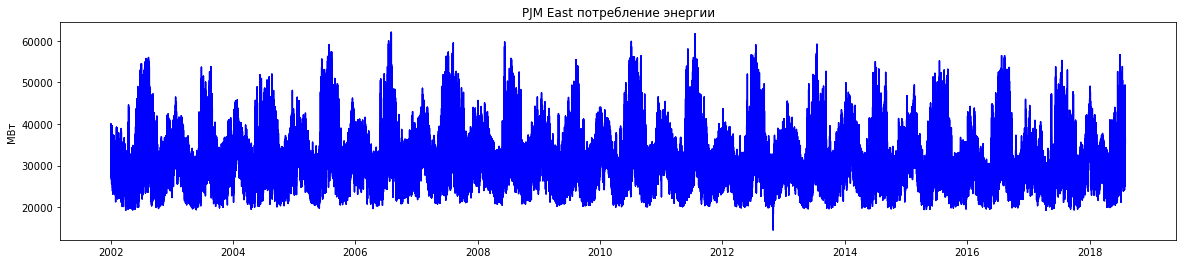

In [3]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [4]:
d_data=data.resample('D').mean()

In [5]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [6]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW'], 0.08)

In [7]:
df = pd.DataFrame(data=data_exp_1, index=d_data.index)
df.head()

,0
Date,
2002-01-01,31080.739130
2002-01-02,31335.203333
2002-01-03,31589.337067
2002-01-04,31759.426768
2002-01-05,31651.082627


In [8]:
# добавим историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)

df.head(10)

,0,t,t1,t2
Date,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000
2002-01-02,31335.203333,31080.739130,0.000000,0.000000
2002-01-03,31589.337067,31335.203333,31080.739130,0.000000
2002-01-04,31759.426768,31589.337067,31335.203333,31080.739130
2002-01-05,31651.082627,31759.426768,31589.337067,31335.203333
2002-01-06,31544.882683,31651.082627,31759.426768,31589.337067
2002-01-07,31687.998735,31544.882683,31651.082627,31759.426768
2002-01-08,31901.992170,31687.998735,31544.882683,31651.082627
2002-01-09,32051.926129,31901.992170,31687.998735,31544.882683


In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [25]:
# разобьем на тест и валид
def split_data_b( data, split_date ):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

train_b, test_b = split_data_b( df, '01-06-2016')

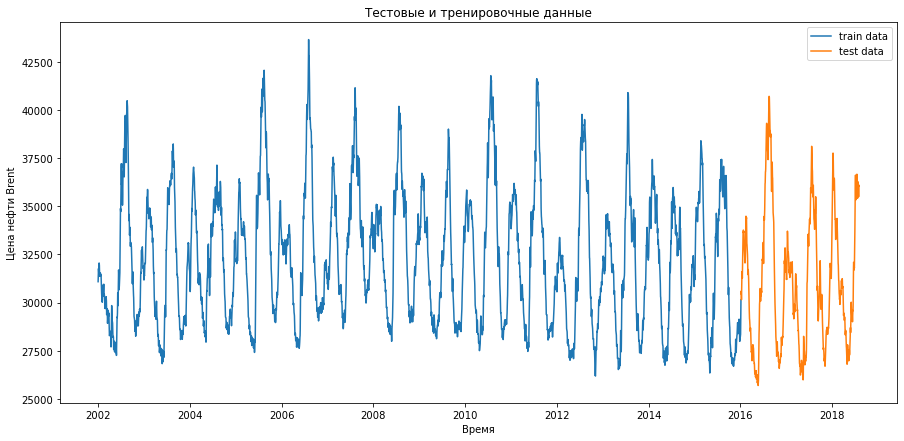

In [26]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(train_b.index,train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index, test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [27]:
h= 1

X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

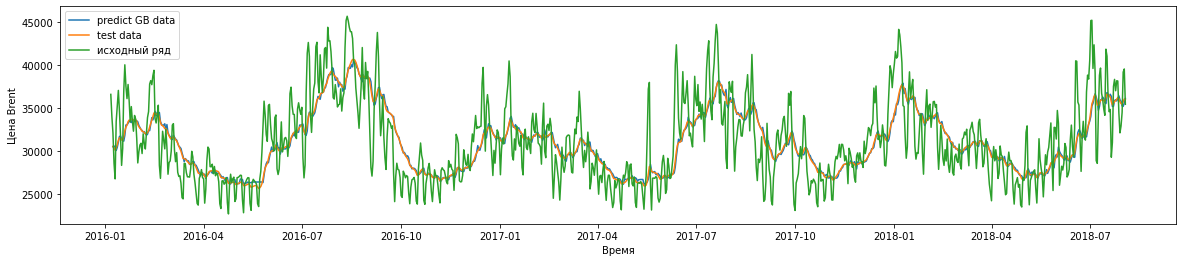

ошибка градиентного бустинга :   0.658751145458866 %


In [29]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(d_data.loc['2016-01-06':].index, d_data.loc['2016-01-06':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

In [30]:
h= 10

X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

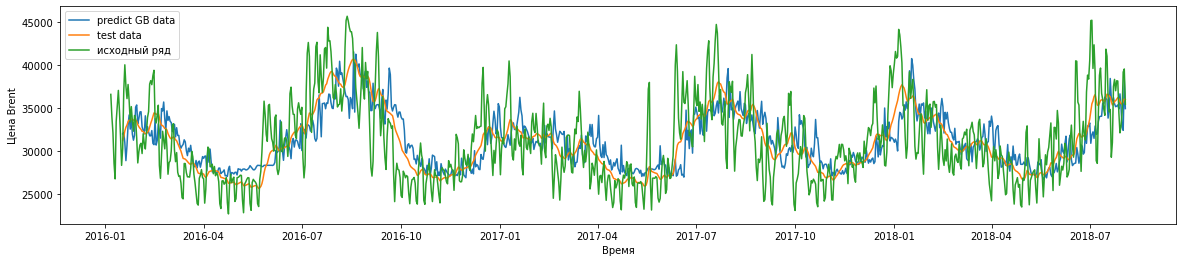

ошибка градиентного бустинга :   4.51856563403939 %


In [31]:
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(d_data.loc['2016-01-06':].index, d_data.loc['2016-01-06':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Модель авторегрессии с горизонтом прогноза $h=1$ имеет ошибку $0.66\%$.

Модель авторегрессии с горизонтом прогноза $h=10$ имеет ошибку $4.5\%$.

С увеличением дальности прогнозирования ошибка растет.

Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном - `нестационарный с сезонностью и циклом, а возможно, и стрендом (глобальное потепление)`.

б) Количество денег, которые тратят покупатели в интернет магазине - `нестационарный с сезонностью и трендом (инфляция)`.

в) Вес растущего котенка - `нестационарный с трендом`.

г) Прирост объема деревьев в лесу от времени - `нестационарный с трендом и сезонностью`.

Какие из рядов на картинке стационарны на первый взгляд?

b h